## imports and db engine

In [64]:
from typing import List, Dict
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
import geoviews as gv
import cartopy.crs as ccrs

import plotly.express as px

from dataclasses import dataclass

from sqlalchemy import create_engine, text
import psycopg2

# -------------------------------------
# Database Configuration (Postgres)
# -------------------------------------
db_config = {
    'host': '143.248.230.55',
    'port': '5432',
    'dbname': 'AIS_DB_Prototype',
    'user': 'root',
    'password': 'password'
}

# Build SQLAlchemy engine
database_url = (
    f"postgresql://{db_config['user']}:{db_config['password']}"
    f"@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"
)
engine = create_engine(database_url)

## Functions

In [67]:
def load_fishing_vessels_voyages(sample_n: int = 5) -> pd.DataFrame:
    """
    Fetch a random sample of voyages (mmsi, eta, destination, shiptype)
    where shiptype ILIKE '%FISHING%' and destination ILIKE '%BUSAN%'.
    Uses a subquery to allow DISTINCT with ORDER BY RANDOM().
    """
    sql = text("""
        SELECT sub.mmsi,
               sub.eta_time,
               sub.destination,
               sub.shiptype
        FROM (
            SELECT DISTINCT 
                mmsi,
                CAST(eta AS TIMESTAMP) AS eta_time,
                destination,
                shiptype
            FROM public.ais_korea
            WHERE shiptype ILIKE '%FISHING%'
        ) AS sub
        ORDER BY RANDOM()
        LIMIT :n;
    """)
    return pd.read_sql(sql, engine, params={"n": sample_n}, parse_dates=["eta_time"])



def load_full_trajectory(mmsi: int, eta_time: pd.Timestamp) -> pd.DataFrame:
    """
    Load ALL AIS points (posutc, latitude, longitude, sog, cog, heading)
    for a given (mmsi, eta) from ais_korea.
    Returns a DataFrame with parsed timestamps.
    """
    sql = text("""
        SELECT 
            posutc AS ts_string,
            latitude,
            longitude,
            sog,
            cog,
            heading
        FROM public.ais_korea
        WHERE mmsi = :m
          AND CAST(eta AS TIMESTAMP) = :e
        ORDER BY posutc::timestamp;
    """)
    df = pd.read_sql(sql, engine, params={"m": mmsi, "e": eta_time})
    df["timestamp"] = pd.to_datetime(df["ts_string"], errors="coerce")
    
    # Convert columns to numeric, coercing invalid values to NaN
    numeric_columns = ["latitude", "longitude", "sog", "cog", "heading"]
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df.drop(columns=["ts_string"], inplace=True)
    # Drop rows where any of the specified columns or timestamp is NaN
    return df.dropna(subset=["timestamp"] + numeric_columns)



def plot_static_trajectory(mmsi: int, eta_time: pd.Timestamp):
    """
    Plot the full trajectory (latitude/longitude) of a single vessel as a line,
    overlaid on an OSM basemap.
    """
    df = load_full_trajectory(mmsi, eta_time)
    if df.empty:
        print(f"No AIS points found for MMSI={mmsi}, ETA={eta_time}")
        return

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )
    gdf_web = gdf.to_crs(epsg=3857)

    # Create a LineString from the sequence of points
    line = LineString(gdf_web.geometry.values.tolist())
    gdf_line = gpd.GeoDataFrame(geometry=[line], crs=gdf_web.crs)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf_line.plot(ax=ax, color="blue", linewidth=2, label="Trajectory")
    # Plot start/end points
    gdf_web.iloc[[0]].plot(ax=ax, color="green", markersize=50, label="Start")
    gdf_web.iloc[[-1]].plot(ax=ax, color="red", markersize=50, label="End")

    # Expand bounds by 10%
    minx, miny, maxx, maxy = gdf_web.total_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)

    # Add basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs=gdf_web.crs.to_string()
    )

    ax.set_title(f"MMSI={mmsi}  |  ETA={eta_time}")
    ax.axis("off")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_interactive_trajectory(mmsi: int, eta_time: pd.Timestamp):
    """
    Interactive map (using GeoViews) showing all AIS points with hover info.
    """
    df = load_full_trajectory(mmsi, eta_time)
    if df.empty:
        print(f"No AIS points for MMSI={mmsi}, ETA={eta_time}")
        return

    traj_points = gv.Points(
        df,
        kdims=["longitude", "latitude"],
        vdims=["timestamp", "sog", "cog", "heading"],
        crs=ccrs.PlateCarree()
    ).opts(
        size=4, color="steelblue", tools=["hover"], alpha=0.7
    )

    tiles = gv.tile_sources.OSM().opts(width=800, height=400)
    overlay = (tiles * traj_points).opts(
        title=f"Interactive Trajectory  |  MMSI={mmsi}  |  ETA={eta_time}"
    )
    return overlay

In [ ]:
# latitude	longitude	sog	cog	heading	timestamp
@dataclass
class AISColumnNames:
    # Date: str = "Date"
    # Sampled_Date: str = "Sampled_Date"
    # Latitude: str = "Latitude"
    # Longitude: str = "Longitude"
    # Pseudo_Longitude: str = "Pseudo_Longitude"
    # SOG: str = "SOG"
    # COG: str = "COG"
    # Heading: str = "Heading"
    
    # n_Latitude: str = "norm Latitude"
    # n_Longitude: str = "norm Longitude"
    # n_SOG: str = "norm SOG"
    # n_COG: str = "norm COG"
    # n_Heading: str = "norm Heading"
    Date: str = "timestamp"
    Sampled_Date: str = "sampled_timestamp"
    Latitude: str = "latitude"
    Longitude: str = "longitude"
    Pseudo_Longitude: str = "pseudo_longitude"
    SOG: str = "sog"
    COG: str = "cog"
    Heading: str = "heading"

    n_Latitude: str = "norm_latitude"
    n_Longitude: str = "norm_longitude"
    n_SOG: str = "norm_sog"
    n_COG: str = "norm_cog"
    n_Heading: str = "norm_heading"

    is_synthetic: str = "is_synthetic"
    to_predict: str = "to_predict"

cols: AISColumnNames = AISColumnNames()
target_freq_in_minutes = 10
target_freq: str = f"{target_freq_in_minutes}min"
sample_T: pd.Timedelta = pd.Timedelta(minutes=target_freq_in_minutes)

def get_sampled_trajectory(trajectory: pd.DataFrame) -> pd.DataFrame:
        trajectory[cols.Date] = pd.to_datetime(trajectory[cols.Date])
        trajectory = trajectory.set_index(cols.Date)
        trajectory = trajectory.sort_index()

        # add first and last steps of trajectory which are divisible by 10 minutes
        first = trajectory.iloc[:1].copy()
        first.index = [trajectory.index.min().floor(target_freq)]
        last = trajectory.iloc[-1:].copy()
        last.index = [trajectory.index.max().ceil(target_freq)]
        trajectory = pd.concat([first, trajectory, last])

        # Define exact 10-minute sampling times
        start_time = trajectory.index.min().floor("h")  # Round down to the nearest hour
        end_time = trajectory.index.max().ceil("h")  # Round up to the nearest hour
        sampling_times = pd.date_range(start_time, end_time, freq=target_freq)

        # Filter only timestamps where at least one real record exists within ±10 minutes
        valid_sampling_times = [
            t
            for t in sampling_times
            if any(abs(trajectory.index - t) <= sample_T)
        ]

        trajectory = trajectory[~trajectory.index.duplicated(keep="first")]
        trajectory_interpolated = trajectory.reindex(
            trajectory.index.union(valid_sampling_times)
        ).sort_index()

        # Perform linear interpolation
        trajectory_interpolated = trajectory_interpolated.interpolate(method="time")

        # Keep only the sampled timestamps and drop any remaining NaNs
        trajectory_sampled = (
            trajectory_interpolated.loc[valid_sampling_times].dropna().reset_index()
        )
        trajectory_sampled.rename(
            columns={"index": cols.Sampled_Date}, inplace=True
        )
        return trajectory_sampled
    
def get_trajectory_sequences(trajectory_sampled: pd.DataFrame, time_column_name=None
    ) -> List[pd.DataFrame]:
        if time_column_name is None:
            time_column_name = cols.Sampled_Date
        trajectory_sequences: List[pd.DataFrame] = []  # To store the sequences
        current_sequence = pd.DataFrame(
            columns=trajectory_sampled.columns
        )  # DF To track the current sequence

        # Iterate through the timestamps
        for i in range(len(trajectory_sampled) - 1):
            if (
                trajectory_sampled[time_column_name][i + 1]
                - trajectory_sampled[time_column_name][i]
                == sample_T
            ):
                # If the difference is 10 minutes, add the current timestamp to the sequence
                if len(current_sequence) == 0:
                    current_sequence = trajectory_sampled.iloc[
                        [i]
                    ]  # Add the first timestamp of the sequence
                current_sequence = pd.concat(
                    [current_sequence, trajectory_sampled.iloc[[i + 1]]],
                    ignore_index=True,
                )  # Add the next timestamp
            else:
                # If the difference is not 10 minutes, end the current sequence
                if len(current_sequence) != 0:
                    trajectory_sequences.append(
                        current_sequence
                    )  # Store the completed sequence
                    current_sequence = pd.DataFrame(
                        columns=trajectory_sampled.columns
                    )  # Reset the current sequence

        # Handle the last sequence if it ends at the last timestamp
        if len(current_sequence) != 0:
            trajectory_sequences.append(current_sequence)

        return trajectory_sequences
    
def plot_plotly_trajectory_groups(df_groups: List[List[pd.DataFrame]],
                         group_names, 
                         color_sequence=None,
                         line_width=2,
                         marker_size=4):
    if not df_groups:
        raise ValueError("Empty list of DataFrame groups provided")
    
    if color_sequence is None:
        color_sequence = px.colors.qualitative.Plotly
    
    # Create empty figure with proper mapbox setup
    fig = px.scatter_mapbox(lat=[None], lon=[None]).update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=8,
        height=600
    )
    min_lat = 360
    max_lat = 0
    min_lon = 360
    max_lon = 0
    for group_id, df_group in enumerate(df_groups):
        group_color = color_sequence[group_id % len(color_sequence)]
        
        for segment_id, df in enumerate(df_group):
            if len(df) == 0:
                continue  # Skip empty dataframes
                
            # Add line trace for this segment
            fig.add_trace(
                px.line_mapbox(
                    df,
                    lat=cols.Latitude,
                    lon=cols.Longitude,
                    color_discrete_sequence=[group_color]
                ).data[0].update(
                    mode="lines+markers",
                    line=dict(width=line_width),
                    marker=dict(size=marker_size),
                    name=f"{group_names[group_id]}",
                    showlegend=(segment_id == 0),  # Only show legend for first segment
                    legendgroup=f"{group_names[group_id]}",
                    hoverinfo="text",
                    customdata=df[[cols.Sampled_Date, cols.SOG, cols.COG]],
                    hovertemplate=(
                        "Latitude: %{lat}<br>"
                        "Longitude: %{lon}<br>"
                        "Date: %{customdata[0]}<br>"
                        "SOG: %{customdata[1]}<br>"
                        "COG: %{customdata[2]}<br>"
                    )
                )
            )
            
            # min/max lat/lot
            min_lat = min(min_lat, df[cols.Latitude].min())
            max_lat = max(max_lat, df[cols.Latitude].max())
            min_lon = min(min_lon, df[cols.Longitude].min())
            max_lon = max(max_lon, df[cols.Longitude].max())
    
    fig.update_layout(
        margin={"r":0,"t":40,"l":0,"b":0},
        showlegend=True,
        legend_title_text="Trajectory Groups",
        title="Vessel Trajectory"
    )
    
    # Auto-zoom to the data
    if len(df_groups) > 0 and len(df_groups[0]) > 0:
        fig.update_mapboxes(
            center=dict(
                lat=(min_lat + max_lat) / 2,
                lon=(min_lon + max_lon) / 2
            )
        )
    
    return fig

## Data extraction

In [38]:
voyages_df = load_fishing_vessels_voyages(sample_n=3)
voyages_df  # display the sample selection

,mmsi,eta_time,destination,shiptype
0,412364398,2023-08-09 10:07:00,LYG,FISHING
1,412364893,2024-01-01 00:00:00,ZHOUSHAN,FISHING
2,440312750,2023-12-12 12:12:00,KR_BUSAN,FISHING


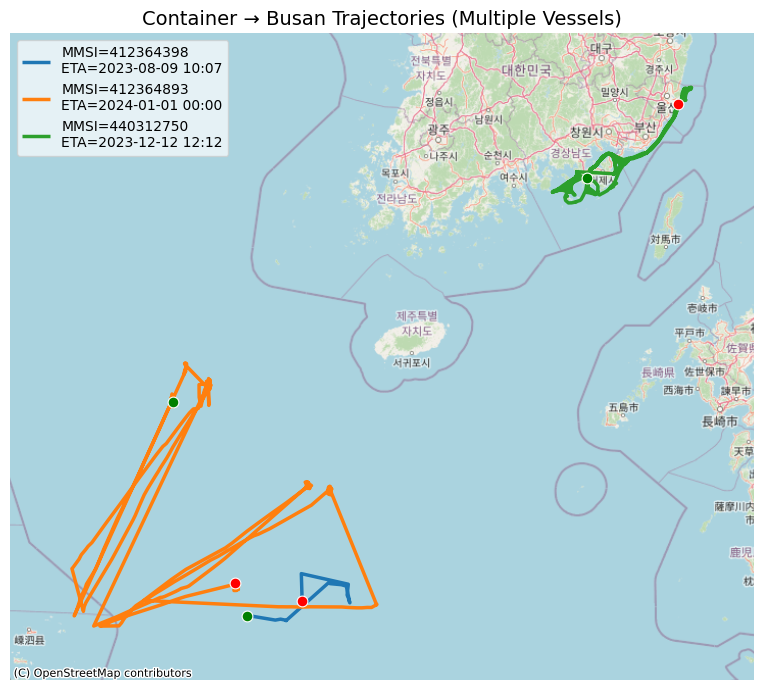

In [56]:
lines = []
labels = []

for idx, row in voyages_df.iterrows():
    m       = int(row["mmsi"])
    eta_val = row["eta_time"]
    dest    = row["destination"]
    stype   = row["shiptype"]
    
    # Load full trajectory points
    df = load_full_trajectory(m, eta_val)

    if df.empty:
        print(f"— Skipping MMSI={m}, no AIS points found.")
        continue
    
    # Convert to Web Mercator to plot on OSM
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
    
    # Create a single LineString from all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append(line)
    
    # Use a label like “MMSI 123… | ETA 2024-01-15”
    labels.append(f"MMSI={m}\nETA={eta_val.strftime('%Y-%m-%d %H:%M')}")

# If no lines were built, skip plotting
if not lines:
    print("No valid trajectories to plot.")
else:
    # Create a GeoDataFrame for all lines
    gdf_lines = gpd.GeoDataFrame(
        {"label": labels},
        geometry=lines,
        crs="EPSG:3857"
    )
    
    # 3) Plot all lines on one figure with distinct colors
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Choose a colormap (here 'tab10' which has up to 10 distinct colors)
    cmap = plt.get_cmap("tab10")
    
    for i, row in gdf_lines.iterrows():
        row_gs = gpd.GeoSeries(row.geometry)
        color = cmap(i % 10)
        row_gs.plot(ax=ax, linewidth=2.5, color=color, label=row["label"])
    
    # 4) Plot start/end points for each vessel
    #    We'll plot a small green circle at the first point, and a red circle at the last point.
    for idx, row in voyages_df.iterrows():
        m       = int(row["mmsi"])
        eta_val = row["eta_time"]
        df = load_full_trajectory(m, eta_val)
        if df.empty:
            continue
        
        # Convert to GeoDataFrame and Web Mercator
        gdf_pts = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df.longitude, df.latitude),
            crs="EPSG:4326"
        ).to_crs(epsg=3857)
        
        # First (start) & last (end) points
        start_pt = gdf_pts.geometry.iloc[0]
        end_pt   = gdf_pts.geometry.iloc[-1]
        
        # Plot start in green, end in red
        ax.scatter(
            [start_pt.x], [start_pt.y],
            s=60, color="green", edgecolor="white", linewidth=0.8, zorder=3
        )
        ax.scatter(
            [end_pt.x], [end_pt.y],
            s=60, color="red", edgecolor="white", linewidth=0.8, zorder=3
        )
    
    # 5) Adjust plot bounds to fit all trajectories
    minx, miny, maxx, maxy = gdf_lines.total_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)
    
    # 6) Add OSM basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )
    
    # 7) Legend and title
    ax.set_title("Container → Busan Trajectories (Multiple Vessels)", fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper left", fontsize=10, framealpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [ ]:
print(m, df)

440312750                 ts_string   latitude   longitude  sog    cog  heading  \
0     2023-12-09 18:09:08  34.829507  128.446327  9.6  167.6      0.0   
1     2023-12-09 18:17:05  34.808545  128.449180  9.8  178.4      0.0   
2     2023-12-09 18:24:27  34.788438  128.446715  9.8  190.2      0.0   
3     2023-12-09 18:48:25  34.722512  128.434203  9.7  192.9      0.0   
4     2023-12-09 18:50:27  34.717198  128.432518  9.6  196.1      0.0   
...                   ...        ...         ...  ...    ...      ...   
1740  2024-02-29 02:45:06  35.458073  129.415932  7.3    5.9      0.0   
1741  2024-02-29 02:54:02  35.472187  129.420530  2.9   56.6      0.0   
1742  2024-02-29 02:55:06  35.472463  129.421403  5.8   79.1      0.0   
1743  2024-02-29 03:35:17  35.475663  129.423357  0.6  114.3      0.0   
1744  2024-02-29 04:00:06  35.475093  129.422815  0.6  241.5      0.0   

               timestamp  
0    2023-12-09 18:09:08  
1    2023-12-09 18:17:05  
2    2023-12-09 18:24:27  
3    

In [80]:
voyages_df = load_fishing_vessels_voyages(sample_n=100)
# voyages_df  # display the sample selection

for idx, row in voyages_df.iterrows():
    print(idx, row)
    try:
        m       = int(row["mmsi"])
        eta_val = row["eta_time"]
        dest    = row["destination"]
        stype   = row["shiptype"]
        
        # Load full trajectory points
        df = load_full_trajectory(m, eta_val)
        sampled_boat_trajectory = get_sampled_trajectory(df)
        # print(sampled_boat_trajectory)
        sampled_boat_trajectory.to_csv(f"../../data/FishingKoreaAIS_sampled_new/len_{len(sampled_boat_trajectory)}_mmsi_{m}_eta_val_{eta_val}_dest_{dest}.csv")
        sample_traj_sequences = get_trajectory_sequences(sampled_boat_trajectory)
        fig = plot_plotly_trajectory_groups([sample_traj_sequences], group_names=["Initial trajectory"])
        fig.write_image(f"../../results/sampled_trajectoryies_Jun9/png_len_{len(sampled_boat_trajectory)}_mmsi_{m}_eta_val_{eta_val}_dest_{dest}.png")
        fig.write_html(f"../../results/sampled_trajectoryies_Jun9/html_len_{len(sampled_boat_trajectory)}_mmsi_{m}_eta_val_{eta_val}_dest_{dest}.html")
    except Exception as e:
        print(f"Couldn't process {row}: e")

0 mmsi                     412433448
eta_time       2024-01-01 00:00:00
destination                 AU PHE
shiptype                   FISHING
Name: 0, dtype: object
1 mmsi                     441294000
eta_time       2024-01-21 00:00:00
destination              JINHAEMAN
shiptype                   FISHING
Name: 1, dtype: object
2 mmsi                     412333816
eta_time       2024-01-01 01:01:00
destination                      0
shiptype                   FISHING
Name: 2, dtype: object
3 mmsi                     273828600
eta_time       2024-03-25 03:40:00
destination            VLADIVOSTOK
shiptype                   FISHING
Name: 3, dtype: object
4 mmsi                     412436673
eta_time       2023-05-16 07:18:00
destination                     11
shiptype                   FISHING
Name: 4, dtype: object
5 mmsi                      273348470
eta_time        2023-10-01 20:00:00
destination    PARK RESEARCH/PATROL
shiptype                    FISHING
Name: 5, dtype: object
Couldn

In [72]:
fig.write_image(f"../../results/sampled_trajectoryies_Jun9/png_len_{len(sampled_boat_trajectory)}_mmsi_{m}_eta_val_{eta_val}_dest_{dest}.png")
fig.write_html(f"../../results/sampled_trajectoryies_Jun9/html_len_{len(sampled_boat_trajectory)}_mmsi_{m}_eta_val_{eta_val}_dest_{dest}.html")
    

In [58]:
trajectory = df.copy()
trajectory[cols.Date] = pd.to_datetime(trajectory[cols.Date])
trajectory = trajectory.set_index(cols.Date)
trajectory = trajectory.sort_index()
# trajectory

# # add first and last steps of trajectory which are divisible by 10 minutes
first = trajectory.iloc[:1].copy()
first.index = [trajectory.index.min().floor(target_freq)]
last = trajectory.iloc[-1:].copy()
last.index = [trajectory.index.max().ceil(target_freq)]
trajectory = pd.concat([first, trajectory, last])

trajectory
# # Define exact 10-minute sampling times
start_time = trajectory.index.min().floor("h")  # Round down to the nearest hour
end_time = trajectory.index.max().ceil("h")  # Round up to the nearest hour
sampling_times = pd.date_range(start_time, end_time, freq=target_freq)

# # Filter only timestamps where at least one real record exists within ±10 minutes
valid_sampling_times = [
    t
    for t in sampling_times
    if any(abs(trajectory.index - t) <= sample_T)
]
# valid_sampling_times

trajectory = trajectory[~trajectory.index.duplicated(keep="first")]
trajectory_interpolated = trajectory.reindex(
    trajectory.index.union(valid_sampling_times)
).sort_index()


# # Perform linear interpolation
trajectory_interpolated = trajectory_interpolated.interpolate(method="time")

# # Keep only the sampled timestamps and drop any remaining NaNs
trajectory_sampled = (
    trajectory_interpolated.loc[valid_sampling_times].dropna().reset_index()
)
trajectory_sampled.rename(
    columns={"index": cols.Sampled_Date}, inplace=True
)
trajectory_sampled


,sampled_timestamp,latitude,longitude,sog,cog,heading
0,2023-12-09 18:00:00,34.829507,128.446327,9.600000,167.600000,0.0
1,2023-12-09 18:10:00,34.827222,128.446638,9.621803,168.777358,0.0
2,2023-12-09 18:20:00,34.800584,128.448204,9.800000,183.071946,0.0
3,2023-12-09 18:30:00,34.773172,128.443818,9.776843,190.825243,0.0
4,2023-12-09 18:40:00,34.745664,128.438597,9.735118,191.951808,0.0
...,...,...,...,...,...,...
957,2024-02-29 03:30:00,35.475243,129.423100,1.283700,109.671879,0.0
958,2024-02-29 03:40:00,35.475555,129.423254,0.600000,138.475688,0.0
959,2024-02-29 04:00:00,35.475096,129.422817,0.600000,240.987441,0.0
960,2024-02-29 04:10:00,35.475093,129.422815,0.600000,241.500000,0.0


In [28]:
type(df["sog"][10])

str

In [29]:
df["sog"][10]

'7.9'